 =================== Starting Tree-Fusion (PCA + Magpie + LGBM) =================== 
Successfully loaded '6059_rows.csv' and 'magpie_features.csv'
 =================== Step 1/5: Aligning data sources =================== 
 =================== Step 2/5: Loading 3D .npy data =================== 
Loaded 4713 3D samples and 4713 1D samples.
 =================== Step 3/5: Applying outlier removal =================== 
Original data shape: 4713
Removed 2 outliers
Data shape after outlier removal: 4711
 =================== Step 4/5: Engineering all 1D features =================== 
PCA complete. Explained variance: 0.8449
Created combined feature matrix with shape: (4711, 644)
 =================== Step 5/5: Creating KFold data splits =================== 
Train/Val/Test shapes: (3768, 644), (471, 644), (472, 644)

 =================== Training High-Performance LGBM ===================
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100627 seconds.
You can s

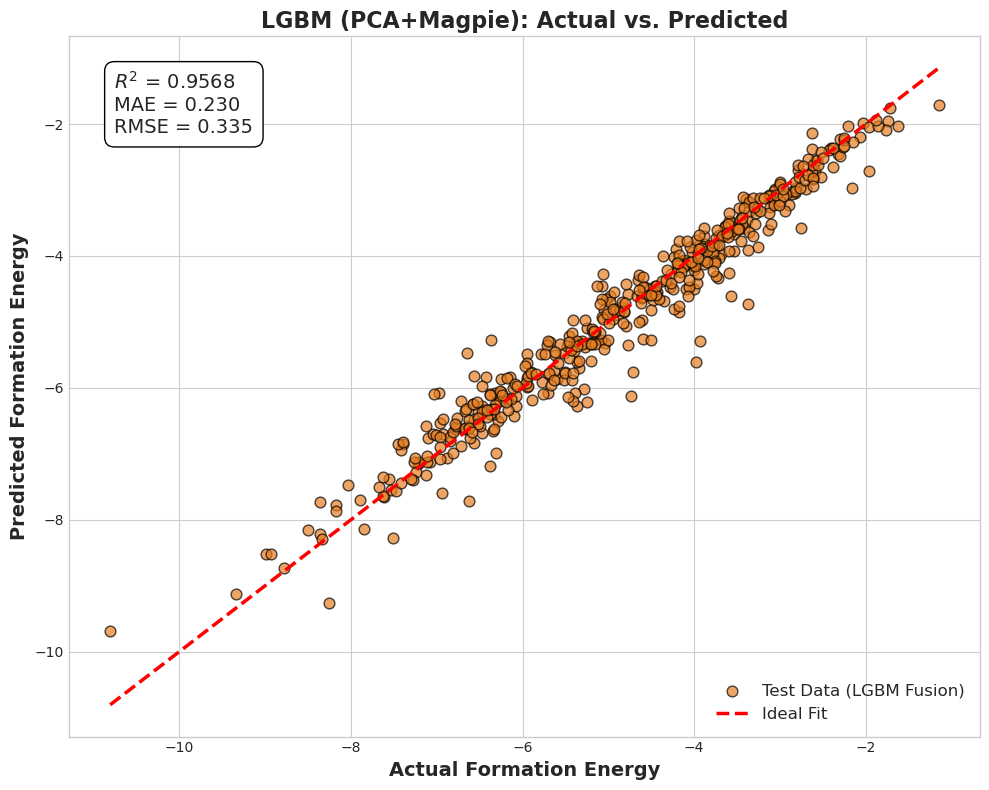

Script complete. Final model saved to 'To_Publish_Formation_Energy_Best_On_CNN.pkl' and plot to 'To_Publish_Formation_Energy_Best_On_CNN.png'


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
import lightgbm as lgb
import joblib
import os
import random
import matplotlib.pyplot as plt
import warnings
from scipy import stats

seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
warnings.filterwarnings('ignore')

print(" =================== Starting Tree-Fusion (PCA + Magpie + LGBM) =================== ")
try:
    df_main = pd.read_csv('6059_data.csv')
    df_magpie = pd.read_csv('magpie_features.csv') 
    print("Successfully loaded '6059_rows.csv' and 'magpie_features.csv'")
except FileNotFoundError as e:
    print(f"Error: Could not find data files. {e}")
    exit()

# --- 2. ALIGN, LOAD, AND CLEAN DATA ---
print(" =================== Step 1/5: Aligning data sources =================== ")
df_main = df_main.dropna(subset=['formation_energy_per_atom']) 
df_aligned = pd.merge(df_main, df_magpie, on='formula_sp', how='inner')
magpie_cols = [col for col in df_magpie.columns if col != 'formula_sp']

print(" =================== Step 2/5: Loading 3D .npy data =================== ")
X_cnn_list = []
y_list = []
input_dir = 'input_cnn'
found_formulas = []
for index, row in df_aligned.iterrows():
    file_path = os.path.join(input_dir, f"{row['formula_sp']}_latent.npy")
    if os.path.exists(file_path):
        X_cnn_list.append(np.load(file_path))
        y_list.append(row['formation_energy_per_atom'])
        found_formulas.append(row['formula_sp'])

df_aligned = df_aligned[df_aligned['formula_sp'].isin(found_formulas)].reset_index(drop=True)
X_magpie = df_aligned[magpie_cols].values
X_3d_raw = np.array(X_cnn_list)
y = np.array(y_list)
print(f"Loaded {X_3d_raw.shape[0]} 3D samples and {X_magpie.shape[0]} 1D samples.")

print(" =================== Step 3/5: Applying outlier removal =================== ")
def remove_outliers_advanced(X_3d_in, X_magpie_in, y_in):
    print(f"Original data shape: {X_3d_in.shape[0]}")
    Q1, Q3 = np.percentile(y_in, [10, 90]); IQR = Q3 - Q1
    mask1 = (y_in >= (Q1 - 2 * IQR)) & (y_in <= (Q3 + 2 * IQR))
    z_scores = np.abs(stats.zscore(y_in)); mask2 = z_scores < 3.5
    mask = mask1 & mask2
    print(f"Removed {len(y_in) - np.sum(mask)} outliers")
    return X_3d_in[mask], X_magpie_in[mask], y_in[mask]

X_3d_raw, X_magpie, y = remove_outliers_advanced(X_3d_raw, X_magpie, y)
print(f"Data shape after outlier removal: {X_3d_raw.shape[0]}")

# --- 3. FEATURE ENGINEERING & SCALING ---
print(" =================== Step 4/5: Engineering all 1D features =================== ")
X_3d_flat = X_3d_raw.reshape(X_3d_raw.shape[0], -1)
scaler_3d = StandardScaler()
X_3d_flat_scaled = scaler_3d.fit_transform(X_3d_flat)

n_components_pca = 512
pca = PCA(n_components=n_components_pca, random_state=seed_value)
X_pca = pca.fit_transform(X_3d_flat_scaled)
print(f"PCA complete. Explained variance: {np.sum(pca.explained_variance_ratio_):.4f}")

scaler_magpie = StandardScaler()
X_magpie_scaled = scaler_magpie.fit_transform(X_magpie)

X_combined = np.concatenate([X_pca, X_magpie_scaled], axis=1)
print(f"Created combined feature matrix with shape: {X_combined.shape}")

# --- 4. SPLITTING ---
print(" =================== Step 5/5: Creating KFold data splits =================== ")
kf = KFold(n_splits=5, shuffle=True, random_state=seed_value)
train_idx, temp_idx = next(kf.split(y))
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=seed_value)

X_train, X_val, X_test = X_combined[train_idx], X_combined[val_idx], X_combined[test_idx]
y_train, y_val, y_test = y[train_idx], y[val_idx], y[test_idx] # Train on raw y

print(f"Train/Val/Test shapes: {X_train.shape}, {X_val.shape}, {X_test.shape}")

# --- 5. TRAIN LIGHTGBM MODEL ---
print("\n =================== Training High-Performance LGBM ===================")
model_lgbm = lgb.LGBMRegressor(
    random_state=seed_value, 
    n_estimators=5000, 
    learning_rate=0.005, 
    num_leaves=127, 
    max_depth=12, 
    min_child_samples=5, 
    subsample=0.8, 
    colsample_bytree=0.7, 
    reg_alpha=0.1, 
    reg_lambda=0.1, 
    min_split_gain=0.01, 
    n_jobs=-1, 
    device='cpu'
)

model_lgbm.fit(
    X_train, y_train, 
    eval_set=[(X_val, y_val)], 
    eval_metric='l2',
    callbacks=[lgb.early_stopping(200, verbose=True)]
)

# --- 6. SAVE THE MODEL ---
model_filename = "To_Publish_Formation_Energy_Best_On_CNN.pkl"
joblib.dump(model_lgbm, model_filename)
print(f"Best model saved to '{model_filename}'")

# --- 7. EVALUATE THE FINAL MODEL ---
print("\n =================== Evaluating Final LGBM Model ===================")
y_pred = model_lgbm.predict(X_test)
y_test_orig = y_test
y_pred_orig = y_pred

r2 = r2_score(y_test_orig, y_pred_orig)
mae = mean_absolute_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))

print("\n" + "="*60); 
print(" =================== FINAL 'TREE-FUSION' MODEL RESULTS ==================="); 
print("="*60)
print(f" R² Score:   {r2:.4f}"); 
print(f" MAE:        {mae:.4f}"); 
print(f" RMSE:       {rmse:.4f}")
print("="*60)

# --- 8. VISUALIZATION ---
print("Generating final plot...")
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 8))

plt.scatter(y_test_orig, y_pred_orig, alpha=0.7, edgecolors='k', c='#e67e22', s=60, label="Test Data (LGBM Fusion)")
ideal_line = [min(y_test_orig.min(), y_pred_orig.min()), max(y_test_orig.max(), y_pred_orig.max())]
plt.plot(ideal_line, ideal_line, 'r--', lw=2.5, label="Ideal Fit")

metrics_text = (
    fr'$R^2$ = {r2:.4f}' + '\n' +
    fr'MAE = {mae:.3f}' + '\n' +
    fr'RMSE = {rmse:.3f}'
)
plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
         fontsize=14, verticalalignment='top', horizontalalignment='left',
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.xlabel("Actual Formation Energy", fontsize=14, fontweight='bold')
plt.ylabel("Predicted Formation Energy", fontsize=14, fontweight='bold')
plt.title(r'LGBM (PCA+Magpie): Actual vs. Predicted', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='lower right')
plt.tight_layout()

plot_filename = "To_Publish_Formation_Energy_Best_On_CNN.png"
plt.savefig(plot_filename, dpi=300)
plt.show()

print(f"Script complete. Final model saved to '{model_filename}' and plot to '{plot_filename}'")